In [ ]:
#Installing the necessary packages for using Bert which plays the role of text encoder 

!pip install timm
!pip install transformers

     |████████████████████████████████| 431 kB 5.4 MB/s 
     |████████████████████████████████| 3.5 MB 5.8 MB/s 
     |████████████████████████████████| 6.8 MB 37.4 MB/s 
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 596 kB 43.6 MB/s 
     |████████████████████████████████| 895 kB 48.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#importing all the necessary packages for implementing clip
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

from torch.utils.data import Dataset
from torchvision import transforms as T 
from PIL import Image 
from itertools import chain 
from glob import glob
import random 
import csv
from torchvision import transforms
import torchvision.transforms.functional as TF

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
from torch.utils.data import DataLoader

In the below cell, we are downloading the Flickr8k dataset to perform contrastive pre-training using image - caption pairs.

In [ ]:
!pip install kaggle --upgrade
os.environ['KAGGLE_USERNAME'] = "sakethbachu"
os.environ['KAGGLE_KEY'] = "a09672b82c0e35e0956b95732b266994"

### For Flickr 8k
!kaggle datasets download -d adityajn105/flickr8k
!unzip flickr8k.zip
dataset = "8k"


### For Flickr 30k
# !kaggle datasets download -d hsankesara/flickr-image-dataset
# !unzip flickr-image-dataset.zip
# dataset = "30k"

In [ ]:
#preprocessing the dataset and setting paths for easy acess
if dataset == "8k":
  df = pd.read_csv("captions.txt")
  df['id'] = [id_ for id_ in range(df.shape[0] // 5) for _ in range(5)]
  df.to_csv("captions.csv", index=False)
  df = pd.read_csv("captions.csv")
  image_path = "/content/Images"
  captions_path = "/content"
elif dataset == "30k":
  df = pd.read_csv("/content/flickr30k_images/results.csv", delimiter="|")
  df.columns = ['image', 'caption_number', 'caption']
  df['caption'] = df['caption'].str.lstrip()
  df['caption_number'] = df['caption_number'].str.lstrip()
  df.loc[19999, 'caption_number'] = "4"
  df.loc[19999, 'caption'] = "A dog runs across the grass ."
  ids = [id_ for id_ in range(len(df) // 5) for _ in range(5)]
  df['id'] = ids
  df.to_csv("captions.csv", index=False)
  image_path = "/content/flickr30k_images/flickr30k_images"
  captions_path = "/content"

df.head()

In [ ]:
#Mounting drive for accessing the dataset
#For more instructions please refer to this blog: https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#setting the paths for different folders of the dataset
FILE_PATH = '/content/drive/MyDrive/sports_dataset/logical-rythm-2k20-sports-image-classification'


TRAIN_PATH = os.path.join(FILE_PATH,'train')
TEST_PATH = os.path.join(FILE_PATH,'test')

TRAIN_IMAGES = os.path.join(TRAIN_PATH,'train')
TEST_IMAGES = os.path.join(TEST_PATH,'test')

#Using pandas to read the csv files which have the ground truth labels
train_df = pd.read_csv(os.path.join(FILE_PATH,'train_labels.csv'))
test_df = pd.read_csv(os.path.join(FILE_PATH,'test_images_list.csv'))


In [ ]:
#listing down the classes
classes = list(train_df['sports'])
classes = list(set(classes))

The below cell is a config block containing the details and hyperparameters of the model.

In [ ]:
#defining a config block to control the hyperparameters of the model 
class CFG:
    debug = False
    image_path = TRAIN_IMAGES
    captions_path = train_df
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 30
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #the image encoder is a resnet50 model
    model_name = 'resnet50'

    #image embedding dimension
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"

    #text embedding dimension
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"

    #We are padding and truncating the captions to a specified max_length which is 200
    max_length = 200

    pretrained = True 
    trainable = True
    temperature = 1.0

    # input image size
    size = 224

    # for projection head
    num_projection_layers = 1
    projection_dim = 256 
    dropout = 0.1

    #finetuning parameters
    finetune_lr = 0.00003
    finetune_epochs = 10
    finetune_warmup_length = 500
    finetune_mode = 'freeze'

In [ ]:
#Helper class for tracking the avg loss and accuracy
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [ ]:
#defining a class to implement the Resnet50 model as an image encoder
# timm is a PyTorch Image Models library, an alternative to this library is torchvision library
#refer the Original paper of resnet: https://arxiv.org/abs/1512.03385
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [ ]:
#defining a class to implement the DistilBert model as a text encoder
#here, we use Distil Bert Model, for a very short information, refer to: https://medium.com/huggingface/distilbert-8cf3380435b5
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state

        #we are using the final representations of the CLS token as this representation captures the overall meaning of caption
        return last_hidden_state[:, self.target_token_idx, :]


#defining a class to implement a finetuning network for the image encoder to perform image classification
#This network is combined with the image encoder to finetune on the classification task after the pretraining paradigm
class finetune_network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(256, 128)
        # Output layer, 22 units - one for each sports class
        self.output = nn.Linear(128, 22)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        
        return x

In [ ]:
#defining a class to implement a projection head network, which will transform the embeddings into a space where the dimensions would be the same
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

#defining the loss function, in our case it is cross entropy
def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [ ]:
#defining the custom dataset class where we need to return image and the encoded caption (using the distil bert). 
#This dataset class is used for pretraining the Clip model on the flikr8k dataset
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        Things to keep in mind:
        1. image_filenames and captions must have the same length; 
        2. so, if there are multiple captions for each image, the image_filenames must have repetitive file names 
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)

        #we encode the caption using a huggingface tokenizers with a max length for each caption
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):

        #setting a dictionary where the keys and values are taken from the tokenizer
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):

        #returns the length of the captions
        return len(self.captions)


#image augmentations, here we resize and normalise the images
def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

In [ ]:
#these two lines help in going from textual classes to their unique numerical indexes and back
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

#this dataloader will help us in finetuning for the sports classification task
class CLIPDataset_classification(torch.utils.data.Dataset):
    def __init__(self,  csv_file, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        #the image filenames and the classes
        self.image_filenames = pd.read_csv(csv_file, error_bad_lines=False, sep=",", header=None, quoting=csv.QUOTE_NONE)
        self.image_filenames = self.image_filenames.iloc[1:,:]

        #captions here are classes of the sports 
        captions = self.image_filenames[1]
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        ext = self.image_filenames.iloc[idx, 0]

        ext = ext[8:]
        image = cv2.imread(f"{CFG.image_path}/{ext}")
        

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        # print(self.captions[idx])

        #converting the tensor to a one hot vector as it is required while performing the classification task
        item['caption'] = F.one_hot(torch.tensor(class_to_idx[self.captions[idx]]), num_classes=22)


        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

In [ ]:
#defining the clip model by putting together all the individual components
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        
        #we use the projection heads to bring both the image embeddings and text embeddings into a space where both the embedding dimensions are same
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        # The entire idea of this step is to make the representation of the information
        # similar even if it is from the caption or the image
        # A best case scenario: The text_embeddings and image_embedding matricies should be the same as they describe similar things
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()

In [ ]:
#this helper function builds the dataframes that carries the training and validation examples (for pretraining)
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe

#this function takes the dataframes built by the above function and constructs data loaders that will be subsequently used for training and validation
def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

The below cell defines a training loop for contrastive pretraining

In [ ]:
#function that takes in the dataloaders and performs forward pass for training process
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


#function that takes in the dataloaders and performs forward pass for validation process
def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


#the main function loads the clip model, dataloaders and calls the training and validation functions for the specified number of epochs
def main():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")
        
        lr_scheduler.step(valid_loss.avg)

In [ ]:
#Running this cell will start training the clip model.
main()

In [ ]:
def get_image_embeddings_test(train_sampler, valid_sampler, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    # valid_loader = build_loaders(valid_df, tokenizer, mode="valid")
    _, valid_loader = build_loaders_test(tokenizer, mode="train", train_sampler=train_sampler, val_sampler = valid_sampler)
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    
    valid_image_embeddings = []
    gts = []
    
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
            iterated_batch = batch["caption"]
            gts.append(iterated_batch)

    return model, torch.cat(valid_image_embeddings), torch.cat(gts)

In [ ]:
train_sampler, valid_sampler, val_indices = make_train_valid_dfs()
model, image_embeddings, iterated = get_image_embeddings_test(train_sampler, valid_sampler, "/content/drive/MyDrive/sports_dataset/logical-rythm-2k20-sports-image-classification/models/best.pth")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
#checking the zero shot accuracy and showing its demo
tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)

text_lists = []

for i in range(0, len(classes)):
  text_i = "a photo of " + str(classes[i])
  tokenized = text_lists.append(tokenizer([text_i]))

# print(text_lists[0])


text_inputs = text_lists

# text_inputs = torch.from_numpy(text_input)


batches = []
for i in range(0, len(classes)):
  batches.append({
    key: torch.tensor(values).to(CFG.device)
    for key, values in text_inputs[i].items()
})
  
# print(batches)


text_embeddings = []
with torch.no_grad():
  for i in range(0, len(batches)):
    
    text_features = model.text_encoder(
        input_ids=batches[i]["input_ids"], attention_mask=batches[i]["attention_mask"]
    )
    text_embeddings.append(model.text_projection(text_features))

text_embeddings = torch.cat(text_embeddings)
# print(text_embeddings)

image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)


similarity = (100.0 * image_embeddings_n @ text_embeddings_n.T).softmax(dim=-1)

values, indices = similarity[5].topk(5)

print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{classes[index]:>16s}: {100 * value.item():.7f}%")


Top predictions:

      ice_hockey: 51.3509810%
          hockey: 42.7152574%
           chess: 3.3577107%
         cricket: 0.4036612%
         kabaddi: 0.3776715%


In [ ]:
#checking the ground truth 
idx_to_class[int(torch.argmax(iterated, dim=1)[5])]

'ice_hockey'

Therefore, we see that the model is not absolutely sure but is on the borderline of both ice hockey and hockey!

In [ ]:
#checking the accuracy of the zeroshot model on the validation set
acc_labels = torch.argmax(iterated, dim=1)
acc_outputs = torch.argmax(similarity, dim=1)
acc_labels = acc_labels.to(CFG.device)
acc_outputs = acc_outputs.to(CFG.device)
accuracy = (acc_outputs == acc_labels).sum()
accuracy = accuracy/iterated.size(0)
accuracy = int(accuracy*100)

print(f"Zero shot accuracy is: {accuracy:.2f}%")

Zero shot accuracy is: 35.00%


We see that the clip model's zero shot accuracy is 35% eventhough it is not directly trained on the sports dataset. This is the power of the CLIP model. It is just trained with flickr images which might have some instances of sports, yet bags 35% accuracy on our task.

In [ ]:
#the functions that are mentioned above are modified to handle the csv files that belong to the sports classification dataset
def make_train_valid_dfs():
    # dataframe = pd.read_csv(train_df)

    #here we split the list of train images into train and validation sets with the ratio of 80:20 ratio

    val_split = 0.2
    shuffle_dataset = True
    random_seed = 42

    dataset_size = len(os.listdir(TRAIN_IMAGES))
    indices = list(range(dataset_size))
    split = int(np.floor(val_split * dataset_size))
    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    #these contain the train and validation indices of the images that are split for the respective purposes
    train_indices, val_indices = indices[split:], indices[:split]

    #these custom data samplers are used for building the dataloaders and can be directly used
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    
    return train_sampler, valid_sampler, val_indices

def make_train_valid_dfs_test():
    # dataframe = pd.read_csv(train_df)

    val_split = 0.2
    shuffle_dataset = True
    random_seed = 42

    dataset_size = len(os.listdir(TRAIN_IMAGES))
    indices = list(range(dataset_size))
    split = int(np.floor(val_split * dataset_size))
    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    
    return train_sampler, valid_sampler, val_indices


def build_loaders(tokenizer, mode, val_sampler, train_sampler):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        csv_file=os.path.join(FILE_PATH,'train_labels.csv'),
        tokenizer=tokenizer,
        transforms=transforms,
    )
    train_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        sampler=train_sampler,
        
    )

    val_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        sampler=val_sampler,
      
    )
    return train_loader, val_loader


def build_loaders_test(tokenizer, mode, val_sampler, train_sampler):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset_classification(
        csv_file=os.path.join(FILE_PATH,'train_labels.csv'),
        tokenizer=tokenizer,
        transforms=transforms,
    )
    train_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        sampler=train_sampler,
        
    )

    val_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        sampler=val_sampler,
      
    )
    return train_loader, val_loader

Now, we take the image encoder of the CLIP model and add an MLP at the end of it to perform classification on the sports image dataset.

In [ ]:
#here we check the untrained validation accuracy of our clip based classification model
def initi_model():
  # tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)    
  model = CLIPModel().to(CFG.device)
  img_enc = model.image_encoder
  img_projector = model.image_projection

  fine_network = finetune_network().to(CFG.device)
  end2end = nn.Sequential(img_enc, img_projector, fine_network)

  return end2end


train_sampler, valid_sampler, _ = make_train_valid_dfs_test()

tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
train_loader, valid_loader = build_loaders_test(tokenizer, mode="train", train_sampler=train_sampler, val_sampler = valid_sampler)

model = initi_model(model_path="/content/drive/MyDrive/sports_dataset/logical-rythm-2k20-sports-image-classification/models/best_finetuned.pth")
model = model.to(CFG.device)

Before we actually finetune it on the sports dataset, we just check what is the accuracy on the validation set.

In [ ]:
def valid_epoch_1(model, valid_loader):
    accuracy_meter = AvgMeter()

    batch_acc = 0

    
    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        # batch = batch.to(CFG.device)

        outputs = model(batch["image"].to(CFG.device))
        labels = batch["caption"].to(CFG.device)
        labels = labels.to(torch.float64)
        output = (torch.argmax(outputs)).float()
        accuracy = (output == labels).float().sum()


        acc_labels = torch.argmax(labels, dim=1)
        acc_outputs = torch.argmax(outputs, dim=1)
        # print(acc_labels.shape)
        # print(acc_outputs)
        accuracy = (acc_outputs == acc_labels).sum()
        accuracy = accuracy/batch["image"].size(0)
        accuracy = int(accuracy*100)
        batch_acc += accuracy



        count = batch["image"].size(0)

        tqdm_object.set_postfix(batch_accuracy=accuracy)

    fin_batch = batch_acc/len(valid_loader)
    # print(f"Validation accuracy before finetuning is: {fin_batch:.2f}%")
    # print("Valid epoch accuracy before finetuning is:", fin_batch)

    return fin_batch


with torch.no_grad():
    valid_accuracy = valid_epoch_1(model, valid_loader)

  0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
print(f"Validation accuracy before finetuning is: {valid_accuracy:.2f}%")


Validation accuracy before finetuning is: 3.83%


We see that it is very low because the weights of the MLP are not yet finetuned for our sports image classification task.

Hence, we finetune the entire network end to end for our task, this paradigm of finetuning it will be very useful for handling out of distribution examples present in the dataset.

In [ ]:
#modifying the above defined functions to suit for the task of classifying the sports images
def train_epoch(model, train_loader, optimizer, lr_scheduler, step, loss_fn):
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    loss_meter = AvgMeter()
    accuracy_meter = AvgMeter()

    batch_acc = 0
    for batch in tqdm_object:
        # batch = batch.to(CFG.device)

        outputs = model(batch["image"].to(CFG.device))
        labels = batch["caption"].to(CFG.device)
        labels = labels.to(torch.float64)
        optimizer.zero_grad()
        loss = loss_fn(outputs, labels)



        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()




        #using argmax for labels aswell because it is a one hot vector        
        acc_labels = torch.argmax(labels, dim=1)
        acc_outputs = torch.argmax(outputs, dim=1)
        # print(acc_labels.shape)
        # print(acc_outputs)
        #we calculate the accuracy of the predictions and return it to the main function
        accuracy = (acc_outputs == acc_labels).sum()
        accuracy = accuracy/batch["image"].size(0)
        accuracy = int(accuracy*100)

        batch_acc += accuracy


        # indices, predicted = torch.max(outputs.data, 0)
        # print(predicted.shape)
        # print(accuracy)
        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer), batch_accuracy=accuracy)

    fin_batch = batch_acc/len(train_loader)
    print("Train epoch accuracy is:", fin_batch)
    return loss_meter, fin_batch


def valid_epoch(model, valid_loader, loss_fn):
    loss_meter = AvgMeter()
    accuracy_meter = AvgMeter()

    batch_acc = 0

    
    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        # batch = batch.to(CFG.device)

        outputs = model(batch["image"].to(CFG.device))
        labels = batch["caption"].to(CFG.device)
        labels = labels.to(torch.float64)
        output = (torch.argmax(outputs)).float()
        accuracy = (output == labels).float().sum()


        loss = loss_fn(outputs, labels)
        acc_labels = torch.argmax(labels, dim=1)
        acc_outputs = torch.argmax(outputs, dim=1)
        # print(acc_labels.shape)
        # print(acc_outputs)
        accuracy = (acc_outputs == acc_labels).sum()
        accuracy = accuracy/batch["image"].size(0)
        accuracy = int(accuracy*100)
        batch_acc += accuracy



        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)
        accuracy_meter.update(accuracy, count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg, batch_accuracy=accuracy)

    fin_batch = batch_acc/len(valid_loader)
    print("Valid epoch accuracy is:", fin_batch)

    return loss_meter, fin_batch


def initi_model2(model_path):
  # tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)    
  model = CLIPModel().to(CFG.device)
  model.load_state_dict(torch.load(model_path, map_location=CFG.device))
  img_enc = model.image_encoder
  img_projector = model.image_projection

  fine_network = finetune_network().to(CFG.device)
  end2end = nn.Sequential(img_enc, img_projector, fine_network)
  return end2end



def main_finetune():
    train_sampler, valid_sampler, _ = make_train_valid_dfs_test()

    # train_sampler = SubsetRandomSampler(short_train)
    # valid_sampler = SubsetRandomSampler(test_indices)
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader, valid_loader = build_loaders_test(tokenizer, mode="train", train_sampler=train_sampler, val_sampler = valid_sampler)



    #here, we load the pretrained clip model's encoder
    model = initi_model2(model_path="/content/drive/MyDrive/sports_dataset/logical-rythm-2k20-sports-image-classification/models/best.pth")
    model = model.to(CFG.device)
    # params = [
    #     {"params": model.parameters(), "lr": CFG.image_encoder_lr},
    #     {"params": itertools.chain(
    #         model.image_projection.parameters(), model.text_projection.parameters()
    #     ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    # ]
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(params, lr = CFG.finetune_lr, weight_decay=0.)
    loss_fn = nn.CrossEntropyLoss()
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )

    ckpt_folder = "/content/drive/MyDrive/sports_dataset/logical-rythm-2k20-sports-image-classification/models/"

    if os.path.exists("/content/drive/MyDrive/sports_dataset/logical-rythm-2k20-sports-image-classification/models/model_weights.pth"):
        checkpoint = torch.load("/content/drive/MyDrive/sports_dataset/logical-rythm-2k20-sports-image-classification/models/model_weights.pth")
        model.load_state_dict(checkpoint['model_state_dict'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        trainLoss = checkpoint['train_loss']
        valLoss = checkpoint['val_loss']
        start_epoch = checkpoint['epoch']


        print("Loaded checkpoint from")
        print("---- Epoch: {} ----\ntrain_loss: {}\n val_loss: {}\n".format( \
                start_epoch+1, trainLoss[-1], valLoss[-1]))
        
    else:
        print("No checkpoint specified. Training from scratch")
        trainLoss = []
        valLoss = []




    step = "epoch"

    best_loss = float('inf')
    correct = 0

    train_l = []
    val_l = []
    train_a = []
    val_a = []
    for epoch in range(CFG.finetune_epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, lr_scheduler, step, loss_fn)

        train_a.append(train_accuracy)
        train_l.append(train_loss)

        trainLoss.append(train_loss)

        val_size = len(valid_loader)
        model.eval()
        with torch.no_grad():
            valid_loss, valid_accuracy = valid_epoch(model, valid_loader, loss_fn)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "/content/drive/MyDrive/sports_dataset/logical-rythm-2k20-sports-image-classification/models/best_finetuned.pth")
            print("Saved Best Model!")

        val_a.append(valid_accuracy)
        val_l.append(valid_loss)
        valLoss.append(valid_loss)
        
        lr_scheduler.step(valid_loss.avg)

        torch.save({
            'epoch':epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_dict': lr_scheduler.state_dict(),
            'train_loss': trainLoss,
            'val_loss': valLoss,
            }, "/content/drive/MyDrive/sports_dataset/logical-rythm-2k20-sports-image-classification/models/model_weights_finetuned.pth")
        

    return train_l, train_a, val_l, val_a

In [ ]:
train_l, train_a, val_l, val_a = main_finetune()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


No checkpoint specified. Training from scratch
Epoch: 1


  0%|          | 0/276 [00:00<?, ?it/s]

Train epoch accuracy is: 22.869565217391305


  0%|          | 0/69 [00:00<?, ?it/s]

Valid epoch accuracy is: 52.927536231884055
Saved Best Model!
Epoch: 2


  0%|          | 0/276 [00:00<?, ?it/s]

Train epoch accuracy is: 66.4927536231884


  0%|          | 0/69 [00:00<?, ?it/s]

Valid epoch accuracy is: 79.71014492753623
Saved Best Model!
Epoch: 3


  0%|          | 0/276 [00:00<?, ?it/s]

Train epoch accuracy is: 82.28260869565217


  0%|          | 0/69 [00:00<?, ?it/s]

Valid epoch accuracy is: 85.82608695652173
Saved Best Model!
Epoch: 4


  0%|          | 0/276 [00:00<?, ?it/s]

Train epoch accuracy is: 87.83333333333333


  0%|          | 0/69 [00:00<?, ?it/s]

Valid epoch accuracy is: 87.14492753623189
Saved Best Model!
Epoch: 5


  0%|          | 0/276 [00:00<?, ?it/s]

Train epoch accuracy is: 90.78985507246377


  0%|          | 0/69 [00:00<?, ?it/s]

Valid epoch accuracy is: 88.42028985507247
Saved Best Model!
Epoch: 6


  0%|          | 0/276 [00:00<?, ?it/s]

Train epoch accuracy is: 92.96376811594203


  0%|          | 0/69 [00:00<?, ?it/s]

Valid epoch accuracy is: 88.92753623188406
Saved Best Model!
Epoch: 7


  0%|          | 0/276 [00:00<?, ?it/s]

Train epoch accuracy is: 94.80434782608695


  0%|          | 0/69 [00:00<?, ?it/s]

Valid epoch accuracy is: 89.15942028985508
Saved Best Model!
Epoch: 8


  0%|          | 0/276 [00:00<?, ?it/s]

Train epoch accuracy is: 96.34057971014492


  0%|          | 0/69 [00:00<?, ?it/s]

Valid epoch accuracy is: 89.31884057971014
Saved Best Model!
Epoch: 9


  0%|          | 0/276 [00:00<?, ?it/s]

Train epoch accuracy is: 97.33333333333333


  0%|          | 0/69 [00:00<?, ?it/s]

Valid epoch accuracy is: 89.46376811594203
Saved Best Model!
Epoch: 10


  0%|          | 0/276 [00:00<?, ?it/s]

Train epoch accuracy is: 98.1340579710145


  0%|          | 0/69 [00:00<?, ?it/s]

Valid epoch accuracy is: 89.47826086956522
Saved Best Model!


In [ ]:
#loading the above trained model and checking for the validation accuracy
def initi_model1(model_path):
  # tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)    
  model = CLIPModel().to(CFG.device)
  img_enc = model.image_encoder
  img_projector = model.image_projection

  fine_network = finetune_network().to(CFG.device)
  end2end = nn.Sequential(img_enc, img_projector, fine_network)
  end2end.load_state_dict(torch.load(model_path, map_location=CFG.device))

  return end2end
train_sampler, valid_sampler, _ = make_train_valid_dfs_test()

# train_sampler = SubsetRandomSampler(short_train)
# valid_sampler = SubsetRandomSampler(test_indices)
tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
train_loader, valid_loader = build_loaders_test(tokenizer, mode="train", train_sampler=train_sampler, val_sampler = valid_sampler)

model1 = initi_model1(model_path="/content/drive/MyDrive/sports_dataset/logical-rythm-2k20-sports-image-classification/models/best_finetuned.pth")
model1 = model1.to(CFG.device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
with torch.no_grad():
    valid_accuracy = valid_epoch_1(model1, valid_loader)

  0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
print(f"Validation accuracy after finetuning is: {valid_accuracy:.2f}%")


Validation accuracy after finetuning is: 88.41%


We see that after finetuning, we get an accuracy of 88% on the validation set.

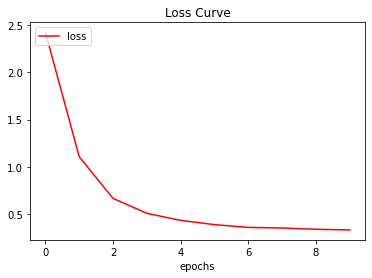

In [ ]:
#visualizing the loss curve and the accuracy curve of the finetuned model
import matplotlib.pyplot as plt

lst_iter = range(10)


plt.plot(lst_iter, val_l, '-r', label="loss")
plt.xlabel("epochs")
plt.legend(loc='upper left')
plt.title("Loss Curve")
plt.savefig("Loss.png")

plt.show()

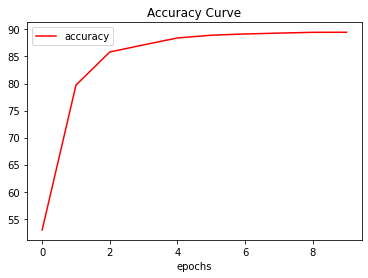

In [ ]:
#visualizing the loss curve and the accuracy curve of the finetuned model
import matplotlib.pyplot as plt

lst_iter = range(10)


plt.plot(lst_iter, val_a, '-r', label="accuracy")
plt.xlabel("epochs")
plt.legend(loc='upper left')
plt.title("Accuracy Curve")
plt.savefig("Accuracy.png")

plt.show()

Here, we use GradCAM to understand the decisions taken by the model in order to classify images into their particular classes.

In [ ]:
def initi_model(model_path):
    # tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)    
    model = CLIPModel().to(CFG.device)
    img_enc = model.image_encoder
    img_projector = model.image_projection


    fine_network = finetune_network().to(CFG.device)
    end2end = nn.Sequential(img_enc, img_projector, fine_network)
    end2end.load_state_dict(torch.load(model_path, map_location=CFG.device))


    
    
    return end2end

#This model will be further used to visualise the predictions using GradCam
model = initi_model(model_path="/content/drive/MyDrive/sports_dataset/logical-rythm-2k20-sports-image-classification/models/best_finetuned.pth")


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import argparse
import cv2
import numpy as np
import torch
from torch.autograd import Function
from torchvision import models

class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):

        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x


class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermediate targetted layers. """

    def __init__(self, model, feature_module, target_layers):

        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)
        
        return target_activations, x


#normalising the image with the mean and standard deviation
def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input

#this helper function helps in taking the class activation maps and then storing it as an image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    cv2_imshow(np.uint8(255 * cam))
    cv2.imwrite("cam.jpg", np.uint8(255 * cam))

#this class takes the model and returns the class activation maps of the model at a speicifed layer inside it.
class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):

        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

#this helper function is used to de-normalise the image to save it
def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img*255)


class GuidedBackpropReLU(Function):

    @staticmethod
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = torch.addcmul(torch.zeros(input.size()).type_as(input), input, positive_mask)
        self.save_for_backward(input, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        input, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input.size()).type_as(input),
                                   torch.addcmul(torch.zeros(input.size()).type_as(input), grad_output,
                                                 positive_mask_1), positive_mask_2)

        return grad_input


class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):

        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                recursive_relu_apply(module)
                if module.__class__.__name__ == 'ReLU':
                    module_top._modules[idx] = GuidedBackpropReLU.apply
                
        # replace ReLU with GuidedBackpropReLU
        recursive_relu_apply(self.model)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            output = self.forward(input.cuda())
        else:
            output = self.forward(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        # self.model.features.zero_grad()
        # self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)

        output = input.grad.cpu().data.numpy()
        output = output[0, :, :, :]

        return output


Here, we visualise the model activations for a given image, i.e we see which pixels fire the neurons and lead the model to classify it in a particular class. In the below example, we give the model a picture of the tennis sport and ask it produce class activation maps.

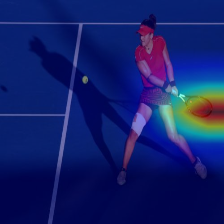

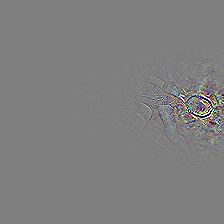

True

In [ ]:
use_cuda = torch.cuda.is_available()                  

#the model whose activations are to be visualised is given here
model_testing = model
model_testing = model_testing.cuda()    

#here we ask the gradcam function to return the activations of the 4th layer
grad_cam = GradCam(model=model_testing[0].model, feature_module=model_testing[0].model.layer4, \
                  target_layer_names=["2"], use_cuda=use_cuda)

#we load a test image to visualise the activations caused by its ground truth class
img = cv2.imread("/content/drive/MyDrive/sports_dataset/logical-rythm-2k20-sports-image-classification/train/train/100.jpg", 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
input = preprocess_image(img)

# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested index.
target_index = None
mask = grad_cam(input, target_index)

show_cam_on_image(img, mask)


gb_model = GuidedBackpropReLUModel(model=model_testing, use_cuda=use_cuda)
# print(model._modules.items())
gb = gb_model(input, index=target_index)
gb = gb.transpose((1, 2, 0))
cam_mask = cv2.merge([mask, mask, mask])
cam_gb = deprocess_image(cam_mask*gb)
gb = deprocess_image(gb)

cv2_imshow(cam_gb)

cv2.imwrite('gb.jpg', gb)
cv2.imwrite('cam_gb.jpg', cam_gb)